🔥 [Start] Corrected Pipeline with Text Transparency

🚀 [Step 1] 바나나 누끼 작업...
   👉 배경 제거 작업 수행 (BiRefNet)...
   Step 1 완료

🚀 [Step 2] 배경 생성 (Model: black-forest-labs/FLUX.1-dev)...


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
100%|██████████| 25/25 [01:01<00:00,  2.45s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


   Step 2 완료

🚀 [Step 3-4] 텍스트 효과 (Model: stabilityai/stable-diffusion-xl-base-1.0)...


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


   👉 생성된 텍스트의 배경을 지웁니다...
   👉 배경 제거 작업 수행 (BiRefNet)...
   Step 3-4 완료

🚀 [Step 5] 레이어 합성 (CPU)...


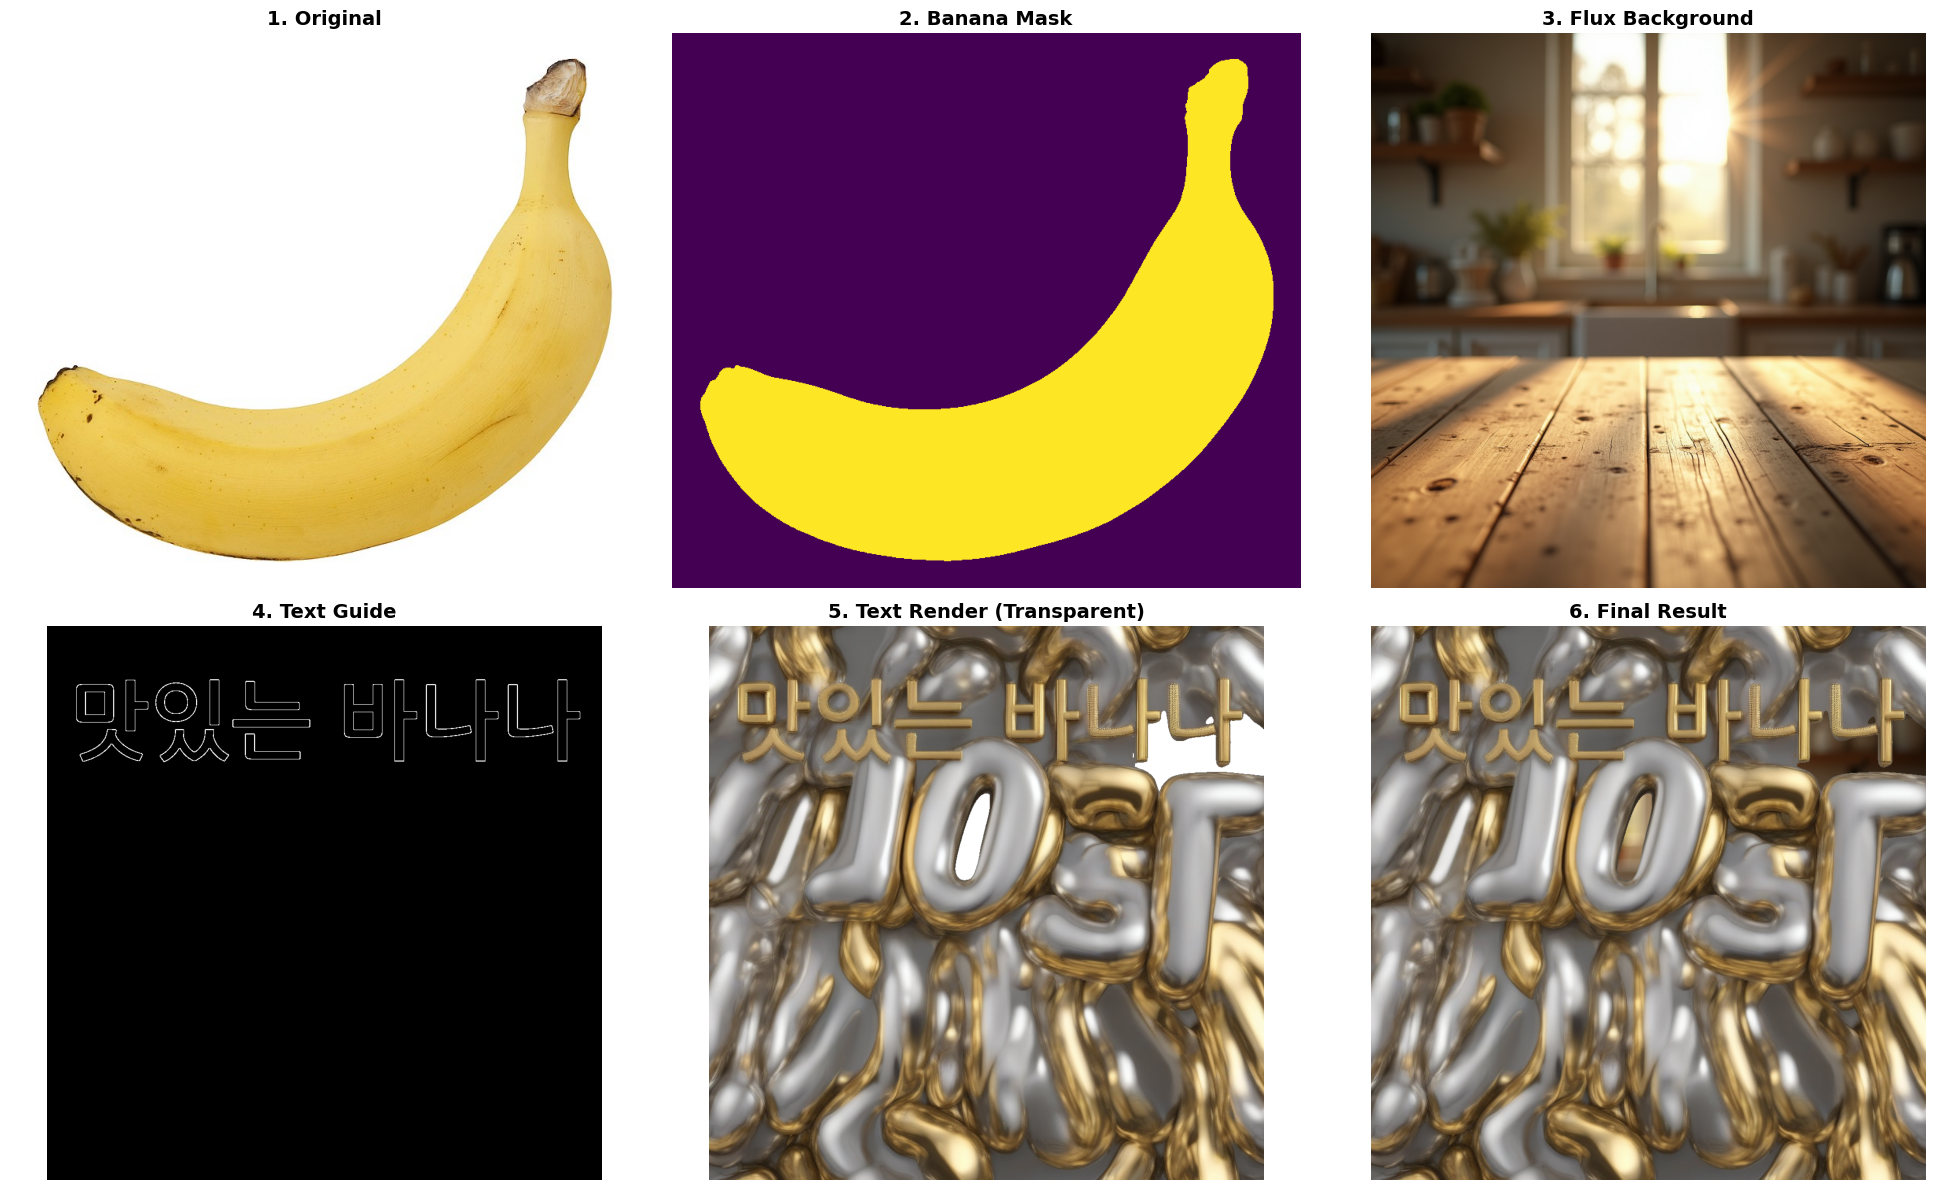

작업 완료: final_result_corrected.png


In [2]:
import torch
import gc
import os
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps
from torchvision import transforms
from transformers import AutoModelForImageSegmentation, BitsAndBytesConfig
from diffusers import (
    FluxPipeline, 
    FluxTransformer2DModel,
    StableDiffusionXLControlNetPipeline, 
    ControlNetModel, 
    AutoencoderKL
)
from diffusers.utils import load_image
import matplotlib.pyplot as plt

# ==========================================
# ⚙️ 통합 설정
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16 

MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev",
    "SDXL_BASE": "stabilityai/stable-diffusion-xl-base-1.0",
    "SDXL_CNET": "diffusers/controlnet-canny-sdxl-1.0",
    "SDXL_VAE": "madebyollin/sdxl-vae-fp16-fix"
}

def flush():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

def download_font(font_name="NanumGothicBold.ttf"):
    if not os.path.exists(font_name):
        url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

def pil_canny_edge(image):
    gray = image.convert("L")
    edges = gray.filter(ImageFilter.FIND_EDGES)
    edges = edges.point(lambda x: 255 if x > 30 else 0)
    return edges.convert("RGB")

def visualize_report(images_dict):
    n = len(images_dict)
    cols = 3
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(20, 6 * rows))
    for i, (title, img) in enumerate(images_dict.items()):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f"{title}", fontsize=14, fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ==========================================
# 🛠️ [Helper] 공용 누끼 함수 (BiRefNet)
# ==========================================
def remove_background_birefnet(image):
    """이미지를 받아 배경을 제거한 RGBA 이미지를 반환합니다."""
    print("   👉 배경 제거 작업 수행 (BiRefNet)...")
    flush()
    
    # Load
    birefnet = AutoModelForImageSegmentation.from_pretrained(
        MODEL_IDS["SEG"], trust_remote_code=True
    ).to(DEVICE).eval()
    
    # Run
    W, H = image.size
    img_resized = image.resize((1024, 1024), Image.LANCZOS)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img_resized).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        preds = birefnet(input_tensor)[-1].sigmoid().cpu()
    
    pred = preds[0].squeeze()
    mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
    mask = mask.point(lambda x: 255 if x > 128 else 0)
    
    result = image.copy()
    result.putalpha(mask)
    
    # Unload
    del birefnet, input_tensor
    flush()
    
    return result, mask

# ==========================================
# [Step 1] 바나나 누끼
# ==========================================
def step1_segmentation(image_path):
    print(f"\n🚀 [Step 1] 바나나 누끼 작업...")
    img = load_image(image_path).convert("RGB")
    
    # 공용 함수 호출
    fg, mask = remove_background_birefnet(img)
    print("   Step 1 완료")
    return img, fg, mask

# ==========================================
# [Step 2] 배경 생성 (Flux)
# ==========================================
def step2_background_flux():
    print(f"\n🚀 [Step 2] 배경 생성 (Model: {MODEL_IDS['FLUX']})...")
    flush()
    
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
    )
    pipe = FluxPipeline.from_pretrained(
        MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload()
    
    prompt = (
        "A close-up view of a rustic wooden table surface. "
        "Soft morning sunlight coming from a window, creating gentle shadows. "
        "Blurred cozy kitchen background, bokeh, photorealistic, 8k, cinematic lighting."
    )
    
    image = pipe(
        prompt, height=1024, width=1024, num_inference_steps=25, guidance_scale=3.5,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    
    del pipe, transformer
    flush()
    print("   Step 2 완료")
    return image

# ==========================================
# [Step 3 & 4] 텍스트 이펙트 (+배경 제거 추가)
# ==========================================
def step3_4_text_effects(text="맛있는 바나나"):
    print(f"\n🚀 [Step 3-4] 텍스트 효과 (Model: {MODEL_IDS['SDXL_BASE']})...")
    flush()
    
    # 가이드 생성
    W, H = 1024, 1024
    font = ImageFont.truetype(download_font(), 160)
    text_guide = Image.new("RGB", (W, H), "black")
    draw = ImageDraw.Draw(text_guide)
    bbox = draw.textbbox((0,0), text, font=font)
    tw = bbox[2] - bbox[0]
    draw.text(((W-tw)//2, 100), text, font=font, fill="white")
    canny_map = pil_canny_edge(text_guide)
    
    # 1. SDXL Load & Run
    controlnet = ControlNetModel.from_pretrained(
        MODEL_IDS["SDXL_CNET"], torch_dtype=TORCH_DTYPE, use_safetensors=True
    )
    vae = AutoencoderKL.from_pretrained(MODEL_IDS["SDXL_VAE"], torch_dtype=TORCH_DTYPE)
    pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
        MODEL_IDS["SDXL_BASE"], controlnet=controlnet, vae=vae, torch_dtype=TORCH_DTYPE
    ).to(DEVICE)
    
    prompt = (
        "3D render of Gold foil balloon text, inflated, shiny metallic texture, "
        "floating in air, cinematic lighting, sharp details, isolated on black background"
    )
    neg_prompt = "flat, 2d, paper, texture, ugly, white background, low quality"
    
    generated_text_img = pipe(
        prompt, negative_prompt=neg_prompt, image=canny_map, 
        controlnet_conditioning_scale=1.0, num_inference_steps=30
    ).images[0]
    
    # 2. SDXL Unload
    del pipe, controlnet, vae
    flush()
    
    # 3. [NEW] 텍스트 배경 제거 (BiRefNet 재사용)
    # 기존의 불완전한 픽셀 지우기 대신, AI 모델로 깔끔하게 지웁니다.
    print("   👉 생성된 텍스트의 배경을 지웁니다...")
    transparent_text, _ = remove_background_birefnet(generated_text_img)
    
    print("   Step 3-4 완료")
    return canny_map, transparent_text

# ==========================================
# [Step 5] 합성 (Composite)
# ==========================================
def step5_composite(bg, fg, text_layer):
    print("\n🚀 [Step 5] 레이어 합성 (CPU)...")
    
    bg_w, bg_h = bg.size
    
    # 1. 바나나 배치
    scale = 0.4
    fg_resized = fg.resize((int(fg.width*scale), int(fg.height*scale)), Image.LANCZOS)
    x = (bg_w - fg_resized.width) // 2
    y = int(bg_h * 0.55)
    
    # 2. 그림자
    fg_mask = fg_resized.split()[-1]
    shadow = Image.new("RGBA", bg.size, (0,0,0,0))
    shadow.paste((0,0,0,140), (x+20, y+40), mask=fg_mask)
    shadow = shadow.filter(ImageFilter.GaussianBlur(30))
    
    # 3. 합성 (배경 -> 그림자 -> 바나나 -> 텍스트)
    comp = bg.convert("RGBA")
    comp = Image.alpha_composite(comp, shadow)
    
    fg_layer = Image.new("RGBA", bg.size)
    fg_layer.paste(fg_resized, (x, y)) # 투명 레이어에 바나나 배치
    comp = Image.alpha_composite(comp, fg_layer) # 배경 위에 바나나 합성
    
    # 텍스트 합성 (이제 투명한 텍스트이므로 배경을 가리지 않음)
    comp = Image.alpha_composite(comp, text_layer)
    
    return comp.convert("RGB")

# ==========================================
# 🚀 메인 실행
# ==========================================
def main_pipeline(image_path):
    print(f"🔥 [Start] Corrected Pipeline with Text Transparency")
    report = {}
    
    # 1. 누끼
    orig, fg, mask = step1_segmentation(image_path)
    report["1. Original"] = orig
    report["2. Banana Mask"] = mask
    
    # 2. 배경
    bg = step2_background_flux()
    report["3. Flux Background"] = bg
    
    # 3. 텍스트 효과 (BiRefNet으로 배경 제거됨)
    canny, text_3d = step3_4_text_effects("맛있는 바나나")
    report["4. Text Guide"] = canny
    report["5. Text Render (Transparent)"] = text_3d
    
    # 4. 합성
    final = step5_composite(bg, fg, text_3d)
    report["6. Final Result"] = final
    
    visualize_report(report)
    final.save("final_result_corrected.png")
    print("작업 완료: final_result_corrected.png")

main_pipeline("image.png")

🔥 [Start] Structured AI Ad Generation Pipeline

🔶 [STAGE A] 베이스 이미지 생성 (배경 + 제품)...
  ➡️ A-1. 제품 누끼 따기
    [AI] BiRefNet 실행 중...
  ➡️ A-2. 배경 장면 생성
    [AI] Flux 실행 중...


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
100%|██████████| 25/25 [01:01<00:00,  2.45s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


  ➡️ A-3. 제품 배치 및 베이스 합성
STAGE A 완료

🔶 [STAGE B] 3D 텍스트 자산 생성...
  ➡️ B-1. 텍스트 가이드 생성 ('맛있는 바나나')
  ➡️ B-2. 3D 텍스트 렌더링
    [AI] SDXL ControlNet 실행 중...


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


  ➡️ B-3. 텍스트 배경 제거 (투명화)
    [AI] BiRefNet 실행 중...
STAGE B 완료

🔶 [STAGE C] 최종 합성...
STAGE C 완료


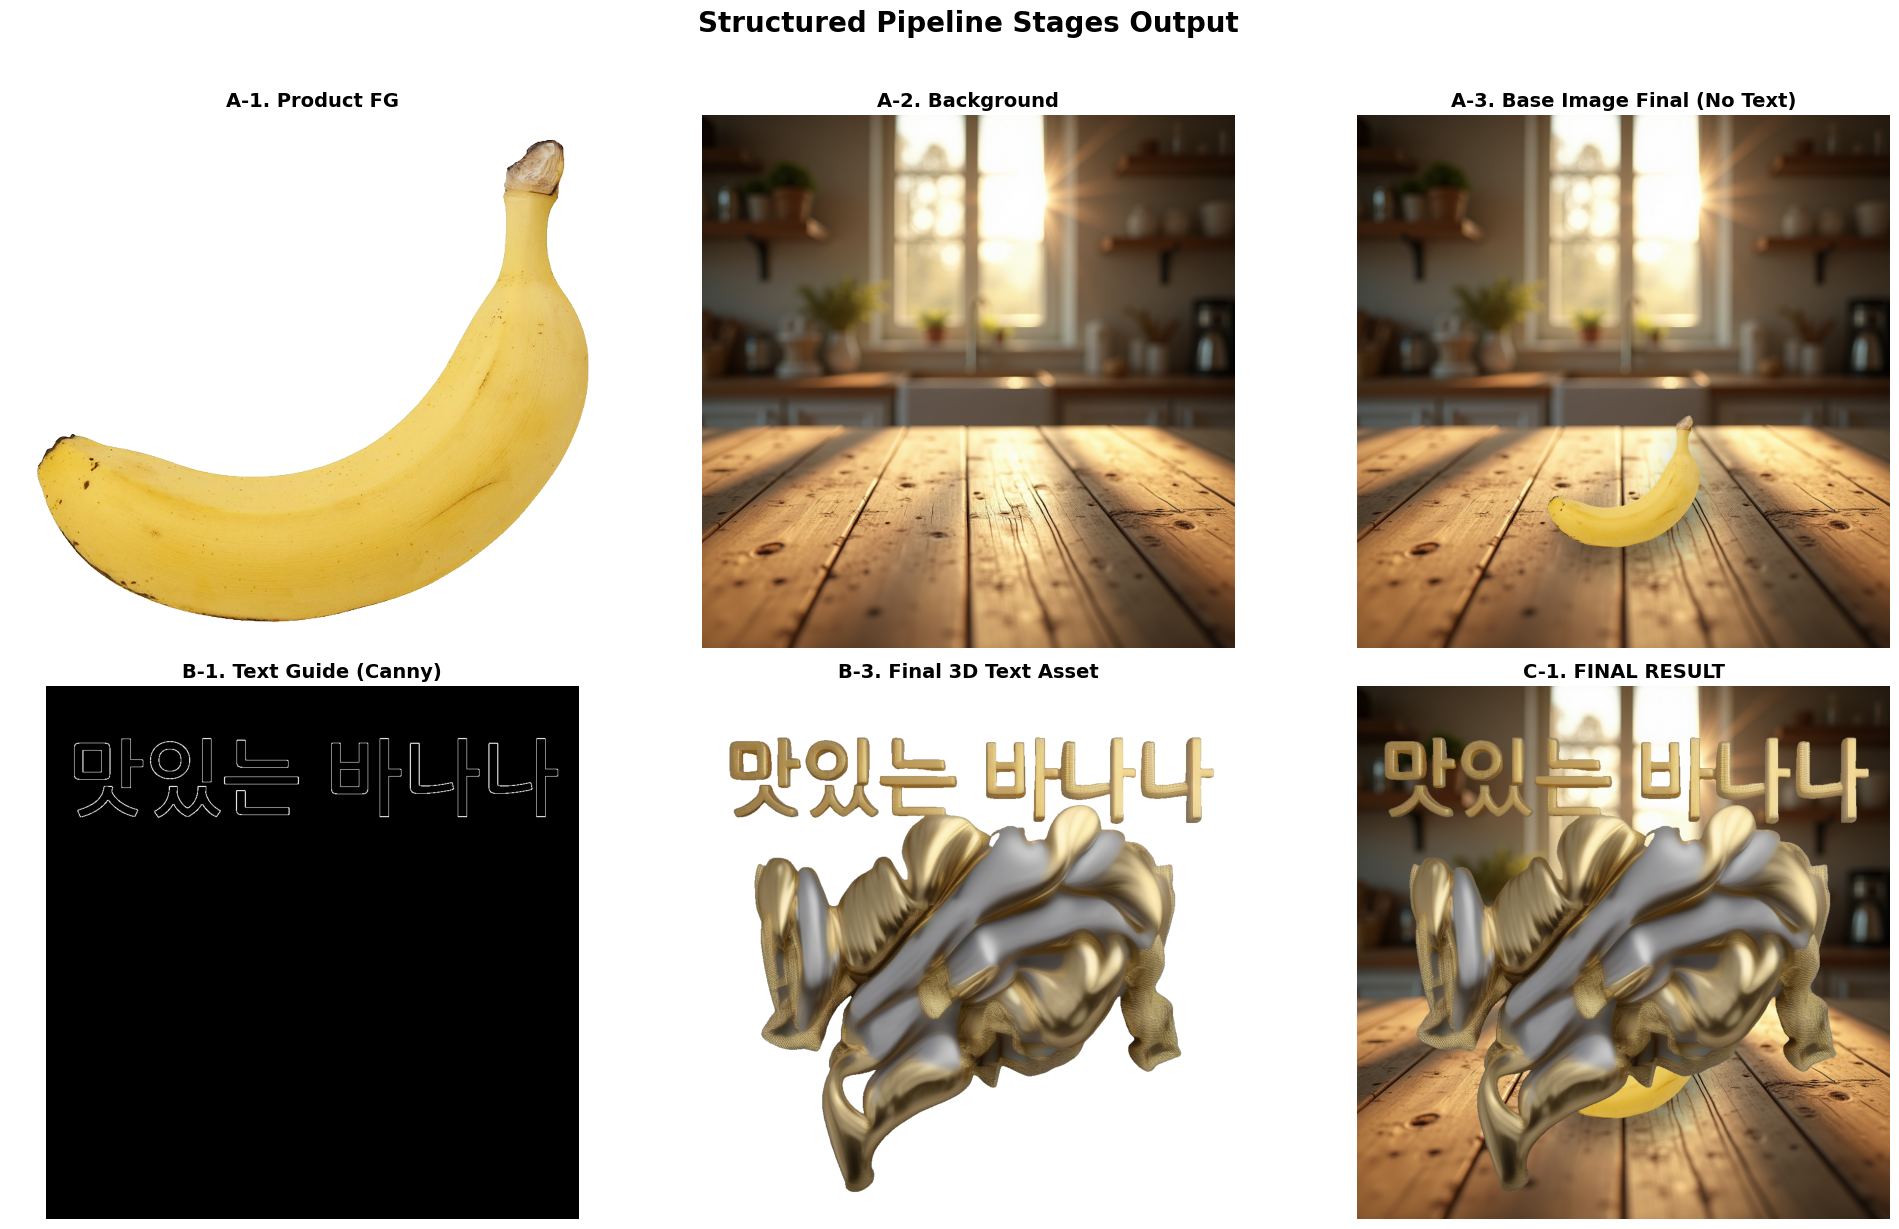


✨ 모든 작업이 완료되었습니다: final_structured_result.png


In [3]:
import torch
import gc
import os
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps
from torchvision import transforms
from transformers import AutoModelForImageSegmentation, BitsAndBytesConfig
from diffusers import (
    FluxPipeline, 
    FluxTransformer2DModel,
    StableDiffusionXLControlNetPipeline, 
    ControlNetModel, 
    AutoencoderKL
)
from diffusers.utils import load_image
import matplotlib.pyplot as plt

# ==========================================
# ⚙️ 설정 및 유틸리티 (설정은 동일)
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16 

MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev",
    "SDXL_BASE": "stabilityai/stable-diffusion-xl-base-1.0",
    "SDXL_CNET": "diffusers/controlnet-canny-sdxl-1.0",
    "SDXL_VAE": "madebyollin/sdxl-vae-fp16-fix"
}

def flush():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

def download_font(font_name="NanumGothicBold.ttf"):
    if not os.path.exists(font_name):
        url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

def pil_canny_edge(image):
    gray = image.convert("L")
    edges = gray.filter(ImageFilter.FIND_EDGES)
    edges = edges.point(lambda x: 255 if x > 30 else 0)
    return edges.convert("RGB")

def visualize_report(images_dict, title="Pipeline Report"):
    n = len(images_dict)
    cols = 3
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(20, 6 * rows))
    plt.suptitle(title, fontsize=20, fontweight='bold', y=1.02)
    for i, (key, img) in enumerate(images_dict.items()):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(key, fontsize=14, fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- 공용 AI 함수 (메모리 관리 포함) ---
def _run_birefnet_seg(image):
    """배경 제거 실행 (BiRefNet)"""
    print("    [AI] BiRefNet 실행 중...")
    flush()
    birefnet = AutoModelForImageSegmentation.from_pretrained(
        MODEL_IDS["SEG"], trust_remote_code=True
    ).to(DEVICE).eval()
    
    W, H = image.size
    img_resized = image.resize((1024, 1024), Image.LANCZOS)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img_resized).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        preds = birefnet(input_tensor)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()
    mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
    mask = mask.point(lambda x: 255 if x > 128 else 0)
    
    result = image.copy()
    result.putalpha(mask)
    del birefnet, input_tensor
    flush()
    return result, mask

def _run_flux_bg_gen():
    """배경 생성 실행 (Flux)"""
    print("    [AI] Flux 실행 중...")
    flush()
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
    )
    pipe = FluxPipeline.from_pretrained(
        MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload() # L4 필수
    
    prompt = (
        "A close-up view of a rustic wooden table surface. "
        "Soft morning sunlight coming from a window, creating gentle shadows. "
        "Blurred cozy kitchen background, bokeh, photorealistic, 8k, cinematic lighting."
    )
    image = pipe(
        prompt, height=1024, width=1024, num_inference_steps=25, guidance_scale=3.5,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    del pipe, transformer
    flush()
    return image

def _run_sdxl_text_gen(canny_map, prompt):
    """3D 텍스트 생성 실행 (SDXL ControlNet)"""
    print("    [AI] SDXL ControlNet 실행 중...")
    flush()
    controlnet = ControlNetModel.from_pretrained(
        MODEL_IDS["SDXL_CNET"], torch_dtype=TORCH_DTYPE, use_safetensors=True
    )
    vae = AutoencoderKL.from_pretrained(MODEL_IDS["SDXL_VAE"], torch_dtype=TORCH_DTYPE)
    pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
        MODEL_IDS["SDXL_BASE"], controlnet=controlnet, vae=vae, torch_dtype=TORCH_DTYPE
    ).to(DEVICE) # Flux가 비워졌으므로 직렬 로드
    
    neg_prompt = "flat, 2d, paper, texture, ugly, white background, low quality"
    generated_img = pipe(
        prompt, negative_prompt=neg_prompt, image=canny_map, 
        controlnet_conditioning_scale=1.0, num_inference_steps=30
    ).images[0]
    del pipe, controlnet, vae
    flush()
    return generated_img

# ==========================================
# 🎨 STAGE A: 베이스 이미지 생성 (Product & Scene)
# ==========================================
def run_stage_a_base_image(image_path):
    print("\n🔶 [STAGE A] 베이스 이미지 생성 (배경 + 제품)...")
    report = {}
    
    # A-1. 제품 누끼 (BiRefNet)
    print("  ➡️ A-1. 제품 누끼 따기")
    raw_img = load_image(image_path).convert("RGB")
    product_fg, product_mask = _run_birefnet_seg(raw_img)
    report["A-1. Product FG"] = product_fg
    
    # A-2. 배경 생성 (Flux)
    print("  ➡️ A-2. 배경 장면 생성")
    bg_img = _run_flux_bg_gen()
    report["A-2. Background"] = bg_img
    
    # A-3. 제품 배치 및 그림자 합성 (PIL)
    print("  ➡️ A-3. 제품 배치 및 베이스 합성")
    bg_w, bg_h = bg_img.size
    scale = 0.4
    fg_resized = product_fg.resize((int(product_fg.width*scale), int(product_fg.height*scale)), Image.LANCZOS)
    fg_mask = fg_resized.split()[-1]
    
    x = (bg_w - fg_resized.width) // 2
    y = int(bg_h * 0.55)
    
    shadow = Image.new("RGBA", bg_img.size, (0,0,0,0))
    shadow.paste((0,0,0,140), (x+20, y+40), mask=fg_mask)
    shadow = shadow.filter(ImageFilter.GaussianBlur(30))
    
    base_composite = bg_img.convert("RGBA")
    base_composite = Image.alpha_composite(base_composite, shadow)
    fg_layer = Image.new("RGBA", bg_img.size)
    fg_layer.paste(fg_resized, (x, y))
    base_composite = Image.alpha_composite(base_composite, fg_layer)
    
    base_image_final = base_composite.convert("RGB")
    report["A-3. Base Image Final (No Text)"] = base_image_final
    
    print("STAGE A 완료")
    return base_image_final, report

# ==========================================
# 🅱️ STAGE B: 3D 타이포그래피 자산 생성
# ==========================================
def run_stage_b_text_asset(text="맛있는 바나나"):
    print("\n🔶 [STAGE B] 3D 텍스트 자산 생성...")
    report = {}
    W, H = 1024, 1024
    
    # B-1. 텍스트 가이드 생성 (PIL)
    print(f"  ➡️ B-1. 텍스트 가이드 생성 ('{text}')")
    font = ImageFont.truetype(download_font(), 160)
    text_guide = Image.new("RGB", (W, H), "black")
    draw = ImageDraw.Draw(text_guide)
    bbox = draw.textbbox((0,0), text, font=font)
    tw = bbox[2] - bbox[0]
    draw.text(((W-tw)//2, 100), text, font=font, fill="white")
    canny_map = pil_canny_edge(text_guide)
    report["B-1. Text Guide (Canny)"] = canny_map
    
    # B-2. 3D 렌더링 (SDXL ControlNet)
    print("  ➡️ B-2. 3D 텍스트 렌더링")
    prompt = (
        "3D render of Gold foil balloon text, inflated, shiny metallic texture, "
        "floating in air, cinematic lighting, sharp details, isolated on black background"
    )
    raw_3d_text = _run_sdxl_text_gen(canny_map, prompt)
    
    # B-3. 텍스트 배경 제거 (BiRefNet 재사용)
    print("  ➡️ B-3. 텍스트 배경 제거 (투명화)")
    transparent_text, _ = _run_birefnet_seg(raw_3d_text)
    report["B-3. Final 3D Text Asset"] = transparent_text
    
    print("STAGE B 완료")
    return transparent_text, report

# ==========================================
# 🖼️ STAGE C: 최종 합성
# ==========================================
def run_stage_c_compositing(base_image, text_asset):
    print("\n🔶 [STAGE C] 최종 합성...")
    
    # C-1. 레이어 합성 (PIL)
    # 베이스 이미지(A) 위에 텍스트 자산(B)을 올리기만 하면 됨
    final_comp = base_image.convert("RGBA")
    final_comp = Image.alpha_composite(final_comp, text_asset)
    
    final_result = final_comp.convert("RGB")
    print("STAGE C 완료")
    return final_result

# ==========================================
# 🚀 메인 파이프라인 실행
# ==========================================
def main_structured_pipeline(image_path):
    print(f"🔥 [Start] Structured AI Ad Generation Pipeline")
    full_report = {}
    
    # --- STAGE A 실행 ---
    base_image, report_a = run_stage_a_base_image(image_path)
    full_report.update(report_a)
    
    # --- STAGE B 실행 ---
    text_asset, report_b = run_stage_b_text_asset("맛있는 바나나")
    full_report.update(report_b)
    
    # --- STAGE C 실행 ---
    final_result = run_stage_c_compositing(base_image, text_asset)
    full_report["C-1. FINAL RESULT"] = final_result
    
    # 결과 확인
    visualize_report(full_report, title="Structured Pipeline Stages Output")
    final_result.save("final_structured_result.png")
    print("\n✨ 모든 작업이 완료되었습니다: final_structured_result.png")

if __name__ == "__main__":
    # 더미 파일 생성 (테스트용)
    if not os.path.exists("image.png"):
        Image.new("RGB", (512, 512), "yellow").save("image.png")
    
    main_structured_pipeline("image.png")